This is a comprehensive outline and implementation structure for a **minimal yet functional Sequence-to-Sequence Transformer model in PyTorch**.

Since the provided source material focuses on the general Transformer architecture and training principles, and does not include specific Chinese-to-English tokenization or data for training a high-quality model, the following program uses **synthetic sequence data** (sequences of integer tokens) to clearly demonstrate the core components and functionality of the Transformer algorithm for a sequence-to-sequence task like machine translation.

The implementation draws heavily from the structure laid out in the source excerpts detailing the PyTorch Transformer implementation.

### Minimal PyTorch Transformer Implementation

The core Transformer model for sequence-to-sequence tasks like translation follows an **Encoder-Decoder structure**. It relies on **Positional Encoding** to inject word order information, as it lacks the inherent sequential processing of Recurrent Neural Networks (RNNs).

#### 1. Positional Encoding Module

The Transformer architecture does not inherently understand the order of a sequence, so positional encoding adds information about the position of each token. It uses sine and cosine functions of different frequencies for this purpose.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from typing import Tuple, Optional


# ======================================================================================
# 1. Positional Encoding
# ======================================================================================

class PositionalEncoding(nn.Module):
    """
    Injects positional information into token embeddings using sine and cosine functions.

    The formula for positional encoding is:
    PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))

    where pos is the position and i is the dimension.
    """

    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        """
        Args:
            d_model: The dimensionality of the model's embeddings
            max_len: Maximum sequence length
            dropout: Dropout probability for regularization
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Shape: (max_len, d_model) -> (1, max_len, d_model) for batch_first
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
        Returns:
            Tensor with positional encoding added
        """
        # Add positional encoding to input embeddings
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

#### 2. The Complete Seq2Seq Transformer Model

This class combines the token embedding layer, the positional encoding, and the core `torch.nn.Transformer` module into a complete sequence-to-sequence architecture. The embedding layer converts discrete token indices into continuous dense vectors (a trainable lookup table).

In [10]:
# ======================================================================================
# 2. The Complete Seq2Seq Transformer Model
# ======================================================================================

class Seq2SeqTransformer(nn.Module):
    """
    Complete Transformer model for sequence-to-sequence tasks.

    Architecture:
    1. Token Embedding + Positional Encoding (Encoder & Decoder)
    2. Transformer Encoder (Multi-head Self-Attention + FFN)
    3. Transformer Decoder (Masked Multi-head Self-Attention + Cross-Attention + FFN)
    4. Linear projection to vocabulary
    """

    def __init__(
            self,
            vocab_size: int,
            d_model: int = 512,
            nhead: int = 8,
            num_encoder_layers: int = 6,
            num_decoder_layers: int = 6,
            dim_feedforward: int = 2048,
            dropout: float = 0.1
    ):
        """
        Args:
            vocab_size: Size of the vocabulary
            d_model: Dimensionality of embeddings (must be divisible by nhead)
            nhead: Number of attention heads
            num_encoder_layers: Number of encoder layers
            num_decoder_layers: Number of decoder layers
            dim_feedforward: Dimension of feedforward network
            dropout: Dropout probability
        """
        super(Seq2SeqTransformer, self).__init__()

        assert d_model % nhead == 0, "d_model must be divisible by nhead"

        self.d_model = d_model

        # Embedding layers (with scaling factor as in "Attention is All You Need")
        self.src_embedding = nn.Embedding(vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(vocab_size, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        # Core Transformer
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # Output projection
        self.generator = nn.Linear(d_model, vocab_size)

        # Initialize parameters
        self._init_parameters()

    def _init_parameters(self):
        """Initialize parameters with Xavier uniform initialization."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(
            self,
            src: torch.Tensor,
            tgt: torch.Tensor,
            src_key_padding_mask: Optional[torch.Tensor] = None,
            tgt_key_padding_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Forward pass through the Transformer.

        Args:
            src: Source sequence (batch_size, src_len)
            tgt: Target sequence (batch_size, tgt_len)
            src_key_padding_mask: Mask for source padding (batch_size, src_len)
            tgt_key_padding_mask: Mask for target padding (batch_size, tgt_len)

        Returns:
            Output logits (batch_size, tgt_len, vocab_size)
        """
        # Create causal mask for decoder (prevents attending to future tokens)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1)).to(src.device)

        # Embed and add positional encoding (with scaling)
        src_emb = self.pos_encoder(self.src_embedding(src) * math.sqrt(self.d_model))
        tgt_emb = self.pos_encoder(self.tgt_embedding(tgt) * math.sqrt(self.d_model))

        # Pass through Transformer
        # shape: (batch_size, tgt_len, d_model)
        transformer_out = self.transformer(
            src=src_emb,
            tgt=tgt_emb,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        # Project to vocabulary
        return self.generator(transformer_out)

#### 3. Data Generation and Training Loop

For a minimal demonstration using PyTorch, we use simplified random data (Source, Target) where the target sequence is simply the source sequence offset, modeling a perfect translation task. In a real Chinese-to-English translation setting, this data generation step would be replaced by actual data loading, tokenization (using methods like BPE), and batching.

In [11]:
# ======================================================================================
# 3. Improved Data Generation
# ======================================================================================

class SyntheticDataGenerator:
    """
    Generates synthetic data for demonstrating Transformer training.

    Task types:
    - 'copy': Target = Source (identity mapping)
    - 'reverse': Target = Reversed source
    - 'sort': Target = Sorted source
    """

    def __init__(self, vocab_size: int, pad_idx: int = 0, sos_idx: int = 1, eos_idx: int = 2):
        self.vocab_size = vocab_size
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx

    def generate_batch(
            self,
            batch_size: int,
            seq_len: int,
            task: str = 'copy'
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Generate a batch of synthetic data.

        Args:
            batch_size: Number of sequences in batch
            seq_len: Length of each sequence
            task: Type of task ('copy', 'reverse', 'sort')

        Returns:
            src: Source sequences
            tgt_input: Target input (for teacher forcing)
            tgt_output: Target output (ground truth)
            src_mask: Source padding mask
            tgt_mask: Target padding mask
        """
        # Generate random source sequences (excluding special tokens)
        src = torch.randint(3, self.vocab_size, (batch_size, seq_len))

        # Generate target based on task
        if task == 'copy':
            tgt = src.clone()
        elif task == 'reverse':
            tgt = torch.flip(src, dims=[1])
        elif task == 'sort':
            tgt = torch.sort(src, dim=1)[0]
        else:
            raise ValueError(f"Unknown task: {task}")

        # Create target input (SOS + target[:-1]) for teacher forcing
        sos_tokens = torch.full((batch_size, 1), self.sos_idx, dtype=torch.long)
        tgt_input = torch.cat([sos_tokens, tgt[:, :-1]], dim=1)

        # Target output is the original target
        tgt_output = tgt

        # Create padding masks (all False for synthetic data without padding)
        src_mask = torch.zeros(batch_size, seq_len, dtype=torch.bool)
        tgt_mask = torch.zeros(batch_size, seq_len, dtype=torch.bool)

        return src, tgt_input, tgt_output, src_mask, tgt_mask

In [12]:
# ======================================================================================
# 4. Training with Learning Rate Scheduling
# ======================================================================================

class NoamOpt:
    """
    Learning rate scheduler from "Attention is All You Need".

    lr = d_model^(-0.5) * min(step^(-0.5), step * warmup_steps^(-1.5))
    """

    def __init__(self, optimizer, d_model: int, warmup_steps: int = 200):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.step_num = 0

    def step(self):
        """Update learning rate and take optimization step."""
        self.step_num += 1
        lr = self._get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        self.optimizer.step()

    def _get_lr(self) -> float:
        """Calculate learning rate based on current step."""
        return (self.d_model ** -0.5) * min(
            self.step_num ** -0.5,
            self.step_num * (self.warmup_steps ** -1.5)
        )

    def zero_grad(self):
        """Zero gradients."""
        self.optimizer.zero_grad()

In [13]:
# ======================================================================================
# 5. Training Loop with Metrics Tracking
# ======================================================================================

def train_model(
        model: nn.Module,
        data_generator: SyntheticDataGenerator,
        device: torch.device,
        epochs: int = 100,
        batch_size: int = 64,
        seq_len: int = 10,
        task: str = 'copy',
        use_noam_opt: bool = True
) -> dict:
    """
    Train the Transformer model with proper tracking and scheduling.

    Returns:
        Dictionary containing training history (losses, accuracies, learning rates)
    """
    criterion = nn.CrossEntropyLoss(ignore_index=data_generator.pad_idx)
    base_optimizer = optim.Adam(model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9)

    if use_noam_opt:
        optimizer = NoamOpt(base_optimizer, model.d_model)
    else:
        optimizer = base_optimizer

    history = {'loss': [], 'accuracy': [], 'lr': []}

    print(f"Starting training on task: '{task}'")
    print(f"Device: {device}")
    print("-" * 60)

    for epoch in range(epochs):
        model.train()

        # Generate batch
        src, tgt_input, tgt_output, src_mask, tgt_mask = data_generator.generate_batch(
            batch_size, seq_len, task
        )
        src = src.to(device)
        tgt_input = tgt_input.to(device)
        tgt_output = tgt_output.to(device)
        src_mask = src_mask.to(device)
        tgt_mask = tgt_mask.to(device)

        # Forward pass
        if use_noam_opt:
            optimizer.zero_grad()
        else:
            optimizer.zero_grad()

        output = model(src, tgt_input, src_mask, tgt_mask)

        # Calculate loss
        output_flat = output.reshape(-1, output.size(-1))
        tgt_flat = tgt_output.reshape(-1)
        loss = criterion(output_flat, tgt_flat)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping

        if use_noam_opt:
            optimizer.step()
            current_lr = optimizer._get_lr()
        else:
            optimizer.step()
            current_lr = optimizer.param_groups[0]['lr']

        # Calculate accuracy
        predictions = output.argmax(dim=-1)
        accuracy = (predictions == tgt_output).float().mean().item()

        # Track metrics
        history['loss'].append(loss.item())
        history['accuracy'].append(accuracy)
        history['lr'].append(current_lr)

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1:3d}/{epochs}] | "
                  f"Loss: {loss.item():.4f} | "
                  f"Acc: {accuracy:.4f} | "
                  f"LR: {current_lr:.6f}")

    print("-" * 60)
    print("Training complete!")
    return history

In [14]:
# ======================================================================================
# 6. Inference with Greedy Decoding
# ======================================================================================

def greedy_decode(
        model: nn.Module,
        src: torch.Tensor,
        max_len: int,
        sos_idx: int,
        eos_idx: int,
        device: torch.device
) -> torch.Tensor:
    """
    Perform greedy decoding for inference.

    Args:
        model: Trained Transformer model
        src: Source sequence (1, src_len)
        max_len: Maximum generation length
        sos_idx: Start-of-sequence token index
        eos_idx: End-of-sequence token index (currently unused, but included for completeness)
        device: Device to run inference on

    Returns:
        Generated sequence (1, gen_len)
    """
    model.eval()
    src = src.to(device)

    # Start with SOS token
    tgt = torch.full((1, 1), sos_idx, dtype=torch.long).to(device)

    with torch.no_grad():
        for _ in range(max_len):
            # Get predictions
            output = model(src, tgt)

            # Get next token (greedy)
            next_token = output[:, -1, :].argmax(dim=-1, keepdim=True)

            # Append to target sequence
            tgt = torch.cat([tgt, next_token], dim=1)

    # Remove SOS token from output
    return tgt[:, 1:]


# ======================================================================================
# 7. Visualization Functions
# ======================================================================================

def plot_training_history(history: dict):
    """Plot training metrics over time."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Loss
    axes[0].plot(history['loss'])
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(history['accuracy'])
    axes[1].set_title('Training Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].grid(True, alpha=0.3)

    # Learning Rate
    axes[2].plot(history['lr'])
    axes[2].set_title('Learning Rate Schedule')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def test_model(
        model: nn.Module,
        data_generator: SyntheticDataGenerator,
        device: torch.device,
        seq_len: int = 10,
        task: str = 'copy',
        num_examples: int = 5
):
    """Test the model and display results."""
    print("\n" + "=" * 60)
    print(f"Testing Model on '{task}' task")
    print("=" * 60)

    for i in range(num_examples):
        # Generate test data
        src, _, tgt_output, _, _ = data_generator.generate_batch(1, seq_len, task)

        # Predict
        predicted = greedy_decode(
            model, src, seq_len,
            data_generator.sos_idx,
            data_generator.eos_idx,
            device
        )

        # Display results
        print(f"\nExample {i + 1}:")
        print(f"  Source:    {src[0].tolist()}")
        print(f"  Expected:  {tgt_output[0].tolist()}")
        print(f"  Predicted: {predicted[0].tolist()}")

        # Check if correct
        is_correct = torch.equal(predicted[0], tgt_output[0].to(device))
        print(f"  Status: {'✓ CORRECT' if is_correct else '✗ INCORRECT'}")

Using device: cpu

Model Parameters: 1,400,606

Starting training on task: 'reverse'
Device: cpu
------------------------------------------------------------


/Users/belter/miniforge3/envs/ds/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch [ 10/1000] | Loss: 3.3401 | Acc: 0.0609 | LR: 0.000313
Epoch [ 20/1000] | Loss: 3.1719 | Acc: 0.0797 | LR: 0.000625
Epoch [ 30/1000] | Loss: 2.8274 | Acc: 0.1500 | LR: 0.000938
Epoch [ 40/1000] | Loss: 2.6739 | Acc: 0.1656 | LR: 0.001250
Epoch [ 50/1000] | Loss: 2.5930 | Acc: 0.1813 | LR: 0.001563
Epoch [ 60/1000] | Loss: 2.4375 | Acc: 0.2219 | LR: 0.001875
Epoch [ 70/1000] | Loss: 2.3393 | Acc: 0.2281 | LR: 0.002188
Epoch [ 80/1000] | Loss: 2.1456 | Acc: 0.2969 | LR: 0.002500
Epoch [ 90/1000] | Loss: 1.8943 | Acc: 0.3578 | LR: 0.002812
Epoch [100/1000] | Loss: 1.7440 | Acc: 0.4156 | LR: 0.003125
Epoch [110/1000] | Loss: 1.5802 | Acc: 0.4453 | LR: 0.003438
Epoch [120/1000] | Loss: 1.8096 | Acc: 0.4078 | LR: 0.003750
Epoch [130/1000] | Loss: 1.3284 | Acc: 0.5609 | LR: 0.004063
Epoch [140/1000] | Loss: 1.1576 | Acc: 0.5906 | LR: 0.004375
Epoch [150/1000] | Loss: 1.0968 | Acc: 0.6219 | LR: 0.004688
Epoch [160/1000] | Loss: 1.0597 | Acc: 0.6547 | LR: 0.005000
Epoch [170/1000] | Loss:

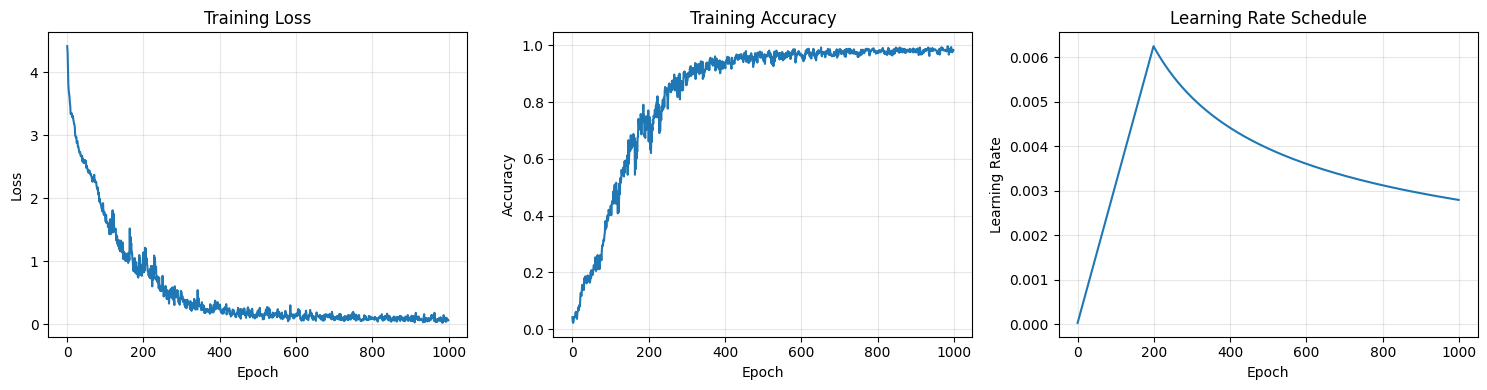


Testing Model on 'reverse' task

Example 1:
  Source:    [10, 8, 24, 10, 17, 4, 20, 23, 6, 15]
  Expected:  [15, 6, 23, 20, 4, 17, 10, 24, 8, 10]
  Predicted: [15, 6, 23, 20, 4, 17, 10, 24, 8, 10]
  Status: ✓ CORRECT

Example 2:
  Source:    [28, 12, 24, 7, 15, 28, 17, 3, 29, 5]
  Expected:  [5, 29, 3, 17, 28, 15, 7, 24, 12, 28]
  Predicted: [5, 29, 3, 17, 28, 15, 7, 24, 12, 28]
  Status: ✓ CORRECT

Example 3:
  Source:    [19, 15, 16, 8, 14, 13, 17, 26, 20, 25]
  Expected:  [25, 20, 26, 17, 13, 14, 8, 16, 15, 19]
  Predicted: [25, 20, 26, 17, 13, 14, 8, 16, 15, 19]
  Status: ✓ CORRECT

Example 4:
  Source:    [18, 28, 9, 28, 27, 5, 13, 19, 14, 28]
  Expected:  [28, 14, 19, 13, 5, 27, 28, 9, 28, 18]
  Predicted: [28, 14, 19, 13, 5, 27, 28, 9, 28, 18]
  Status: ✓ CORRECT

Example 5:
  Source:    [7, 26, 19, 12, 28, 21, 11, 22, 22, 23]
  Expected:  [23, 22, 22, 11, 21, 28, 12, 19, 26, 7]
  Predicted: [23, 22, 22, 11, 21, 28, 12, 19, 26, 7]
  Status: ✓ CORRECT


In [15]:
# ======================================================================================
# 8. Main Execution
# ======================================================================================

if __name__ == "__main__":
    # Hyperparameters
    VOCAB_SIZE = 30
    D_MODEL = 128
    NHEAD = 8
    NUM_ENCODER_LAYERS = 3
    NUM_DECODER_LAYERS = 3
    DIM_FEEDFORWARD = 512
    DROPOUT = 0.1

    SEQ_LEN = 10
    BATCH_SIZE = 64
    EPOCHS = 1000
    TASK = 'reverse'  # Options: 'copy', 'reverse', 'sort'

    # Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # Initialize model
    model = Seq2SeqTransformer(
        vocab_size=VOCAB_SIZE,
        d_model=D_MODEL,
        nhead=NHEAD,
        num_encoder_layers=NUM_ENCODER_LAYERS,
        num_decoder_layers=NUM_DECODER_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        dropout=DROPOUT
    ).to(device)

    print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
    print()

    # Initialize data generator
    data_generator = SyntheticDataGenerator(vocab_size=VOCAB_SIZE)

    # Train
    history = train_model(
        model=model,
        data_generator=data_generator,
        device=device,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        seq_len=SEQ_LEN,
        task=TASK,
        use_noam_opt=True
    )

    # Plot training history
    plot_training_history(history)

    # Test model
    test_model(
        model=model,
        data_generator=data_generator,
        device=device,
        seq_len=SEQ_LEN,
        task=TASK,
        num_examples=5
    )